In [1]:
import keras

E:\softwares\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
import os

data_dir = 'E:\deep learning datasets\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

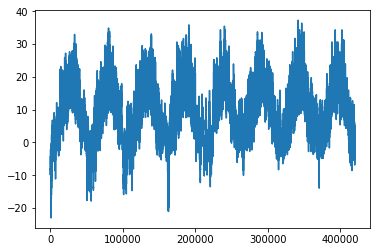

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

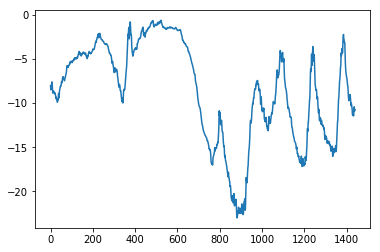

In [9]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [10]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 29ms/step - loss: 1.0853 - val_loss: 0.4842
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3359 - val_loss: 0.3141
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2751 - val_loss: 0.3129
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2583 - val_loss: 0.3479
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2457 - val_loss: 0.3030
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2371 - val_loss: 0.3277
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2326 - val_loss: 0.3058
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2267 - val_loss: 0.3277
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2246 - val_loss: 0.3189
Epoch 10/20
500/500 [==============================] - 10s 21ms/step - loss: 0.219

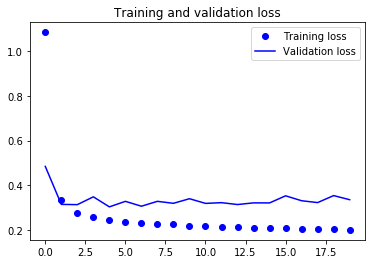

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 196s 391ms/step - loss: 0.3020 - val_loss: 0.2708
Epoch 2/20
500/500 [==============================] - 196s 392ms/step - loss: 0.2867 - val_loss: 0.2665
Epoch 3/20
500/500 [==============================] - 195s 390ms/step - loss: 0.2778 - val_loss: 0.2646
Epoch 4/20
500/500 [==============================] - 194s 388ms/step - loss: 0.2739 - val_loss: 0.2614
Epoch 5/20
500/500 [==============================] - 194s 389ms/step - loss: 0.2676 - val_loss: 0.2609
Epoch 6/20
500/500 [==============================] - 194s 389ms/step - loss: 0.2669 - val_loss: 0.2655
Epoch 7/20
500/500 [==============================] - 194s 388ms/step - loss: 0.2612 - val_loss: 0.2604
Epoch 8/20
500/500 [==============================] - 196s 392ms/step - loss: 0.2562 - val_loss: 0.2629
Epoch 9/20
500/500 [==============================] - 194s 389ms/step - loss: 0.2513 - val_loss: 0.2639
Epoch 10/20
500/500 [==============================] - 194s 388m

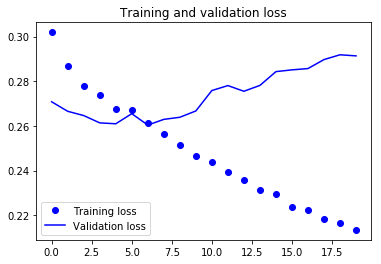

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 201s 402ms/step - loss: 0.3387 - val_loss: 0.2774
Epoch 2/40
500/500 [==============================] - 193s 387ms/step - loss: 0.3150 - val_loss: 0.2743
Epoch 3/40
500/500 [==============================] - 195s 389ms/step - loss: 0.3078 - val_loss: 0.2738
Epoch 4/40
500/500 [==============================] - 214s 427ms/step - loss: 0.3035 - val_loss: 0.2732
Epoch 5/40
500/500 [==============================] - 213s 427ms/step - loss: 0.3005 - val_loss: 0.2711
Epoch 6/40
500/500 [==============================] - 204s 409ms/step - loss: 0.2965 - val_loss: 0.2665
Epoch 7/40
500/500 [==============================] - 195s 390ms/step - loss: 0.2938 - val_loss: 0.2680
Epoch 8/40
500/500 [==============================] - 193s 387ms/step - loss: 0.2930 - val_loss: 0.2673
Epoch 9/40
500/500 [==============================] - 199s 399ms/step - loss: 0.2928 - val_loss: 0.2681
Epoch 10/40
500/500 [==============================] - 207s 415m

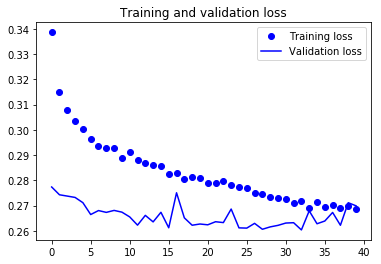

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 383s 765ms/step - loss: 0.3360 - val_loss: 0.2815
Epoch 2/40
500/500 [==============================] - 379s 758ms/step - loss: 0.3129 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 389s 778ms/step - loss: 0.3070 - val_loss: 0.2668
Epoch 4/40
500/500 [==============================] - 424s 847ms/step - loss: 0.3012 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 458s 917ms/step - loss: 0.2998 - val_loss: 0.2643
Epoch 6/40
500/500 [==============================] - 393s 786ms/step - loss: 0.2969 - val_loss: 0.2717
Epoch 7/40
500/500 [==============================] - 486s 971ms/step - loss: 0.2931 - val_loss: 0.2747
Epoch 8/40
500/500 [==============================] - 658s 1s/step - loss: 0.2912 - val_loss: 0.2677
Epoch 9/40
500/500 [==============================] - 618s 1s/step - loss: 0.2882 - val_loss: 0.2669
Epoch 10/40
500/500 [==============================] - 615s 1s/step - 

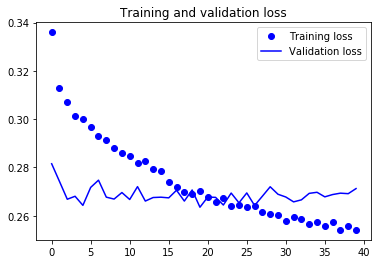

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [20]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 205s 409ms/step - loss: 0.4805 - val_loss: 0.4858
Epoch 2/20
500/500 [==============================] - 208s 416ms/step - loss: 0.4545 - val_loss: 0.4843
Epoch 3/20
500/500 [==============================] - 204s 408ms/step - loss: 0.4303 - val_loss: 0.4652
Epoch 4/20
500/500 [==============================] - 201s 402ms/step - loss: 0.3991 - val_loss: 0.4691
Epoch 5/20
500/500 [==============================] - 193s 385ms/step - loss: 0.3736 - val_loss: 0.4722
Epoch 6/20
500/500 [==============================] - 180s 359ms/step - loss: 0.3539 - val_loss: 0.4520
Epoch 7/20
500/500 [==============================] - 224s 448ms/step - loss: 0.3311 - val_loss: 0.4658
Epoch 8/20
500/500 [==============================] - 237s 475ms/step - loss: 0.3127 - val_loss: 0.4586
Epoch 9/20
500/500 [==============================] - 238s 477ms/step - loss: 0.2982 - val_loss: 0.4643
Epoch 10/20
500/500 [==============================] - 237s 475m

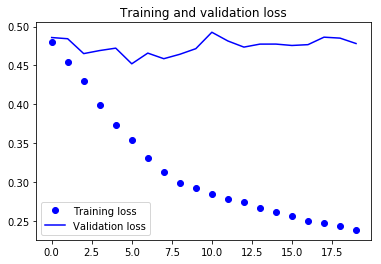

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

***LSTM IMDB***

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

E:\softwares\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 128s 6ms/step - loss: 0.4863 - acc: 0.7702 - val_loss: 0.3413 - val_acc: 0.8696
Epoch 2/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.3061 - acc: 0.8828 - val_loss: 0.4167 - val_acc: 0.8150
Epoch 3/10
20000/20000 [==============================] - 125s 6ms/step - loss: 0.2559 - acc: 0.9057 - val_loss: 0.3148 - val_acc: 0.8732
Epoch 4/10
20000/20000 [==============================] - 133s 7ms/step - loss: 0.2188 - acc: 0.9203 - val_loss: 0.4171 - val_acc: 0.8618
Epoch 5/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.1907 - acc: 0.9326 - val_loss: 0.3523 - val_acc: 0.8826
Epoch 6/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.1691 - acc: 0.9412 - val_loss: 0.3625 - val_acc: 0.8788
Epoch 7/10
20000/20000 [==============================] - 139s 7ms/step - loss: 0.1523 - acc: 0.9473 - val_loss: 0.4387 - v

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 412s 21ms/step - loss: 0.5599 - acc: 0.7172 - val_loss: 0.4341 - val_acc: 0.8244
Epoch 2/10
20000/20000 [==============================] - 436s 22ms/step - loss: 0.3732 - acc: 0.8614 - val_loss: 0.4563 - val_acc: 0.8006
Epoch 3/10
20000/20000 [==============================] - 440s 22ms/step - loss: 0.2639 - acc: 0.9038 - val_loss: 0.4267 - val_acc: 0.8662
Epoch 4/10
20000/20000 [==============================] - 415s 21ms/step - loss: 0.2297 - acc: 0.9174 - val_loss: 0.3121 - val_acc: 0.8852
Epoch 5/10
20000/20000 [==============================] - 409s 20ms/step - loss: 0.2080 - acc: 0.9257 - val_loss: 0.3280 - val_acc: 0.8888
Epoch 6/10
20000/20000 [==============================] - 409s 20ms/step - loss: 0.1852 - acc: 0.9351 - val_loss: 0.3973 - val_acc: 0.8660
Epoch 7/10
20000/20000 [==============================] - 409s 20ms/step - loss: 0.1739 - acc: 0.9419 - val_loss: 0.4

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 382s 763ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 374s 748ms/step - loss: 0.2743 - val_loss: 0.2716
Epoch 3/40
500/500 [==============================] - 370s 739ms/step - loss: 0.2666 - val_loss: 0.2689
Epoch 4/40
500/500 [==============================] - 382s 765ms/step - loss: 0.2628 - val_loss: 0.2705
Epoch 5/40
500/500 [==============================] - 332s 665ms/step - loss: 0.2553 - val_loss: 0.2730
Epoch 6/40
500/500 [==============================] - 325s 650ms/step - loss: 0.2488 - val_loss: 0.2715
Epoch 7/40
500/500 [==============================] - 326s 651ms/step - loss: 0.2448 - val_loss: 0.2799
Epoch 8/40
500/500 [==============================] - 371s 741ms/step - loss: 0.2399 - val_loss: 0.2820
Epoch 9/40
500/500 [==============================] - 452s 905ms/step - loss: 0.2334 - val_loss: 0.2822
Epoch 10/40
500/500 [==============================] - 440s 881m